## Paquetes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

c:\Users\user\mambaforge\envs\analogTS\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Carga de datos

In [2]:
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

In [3]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


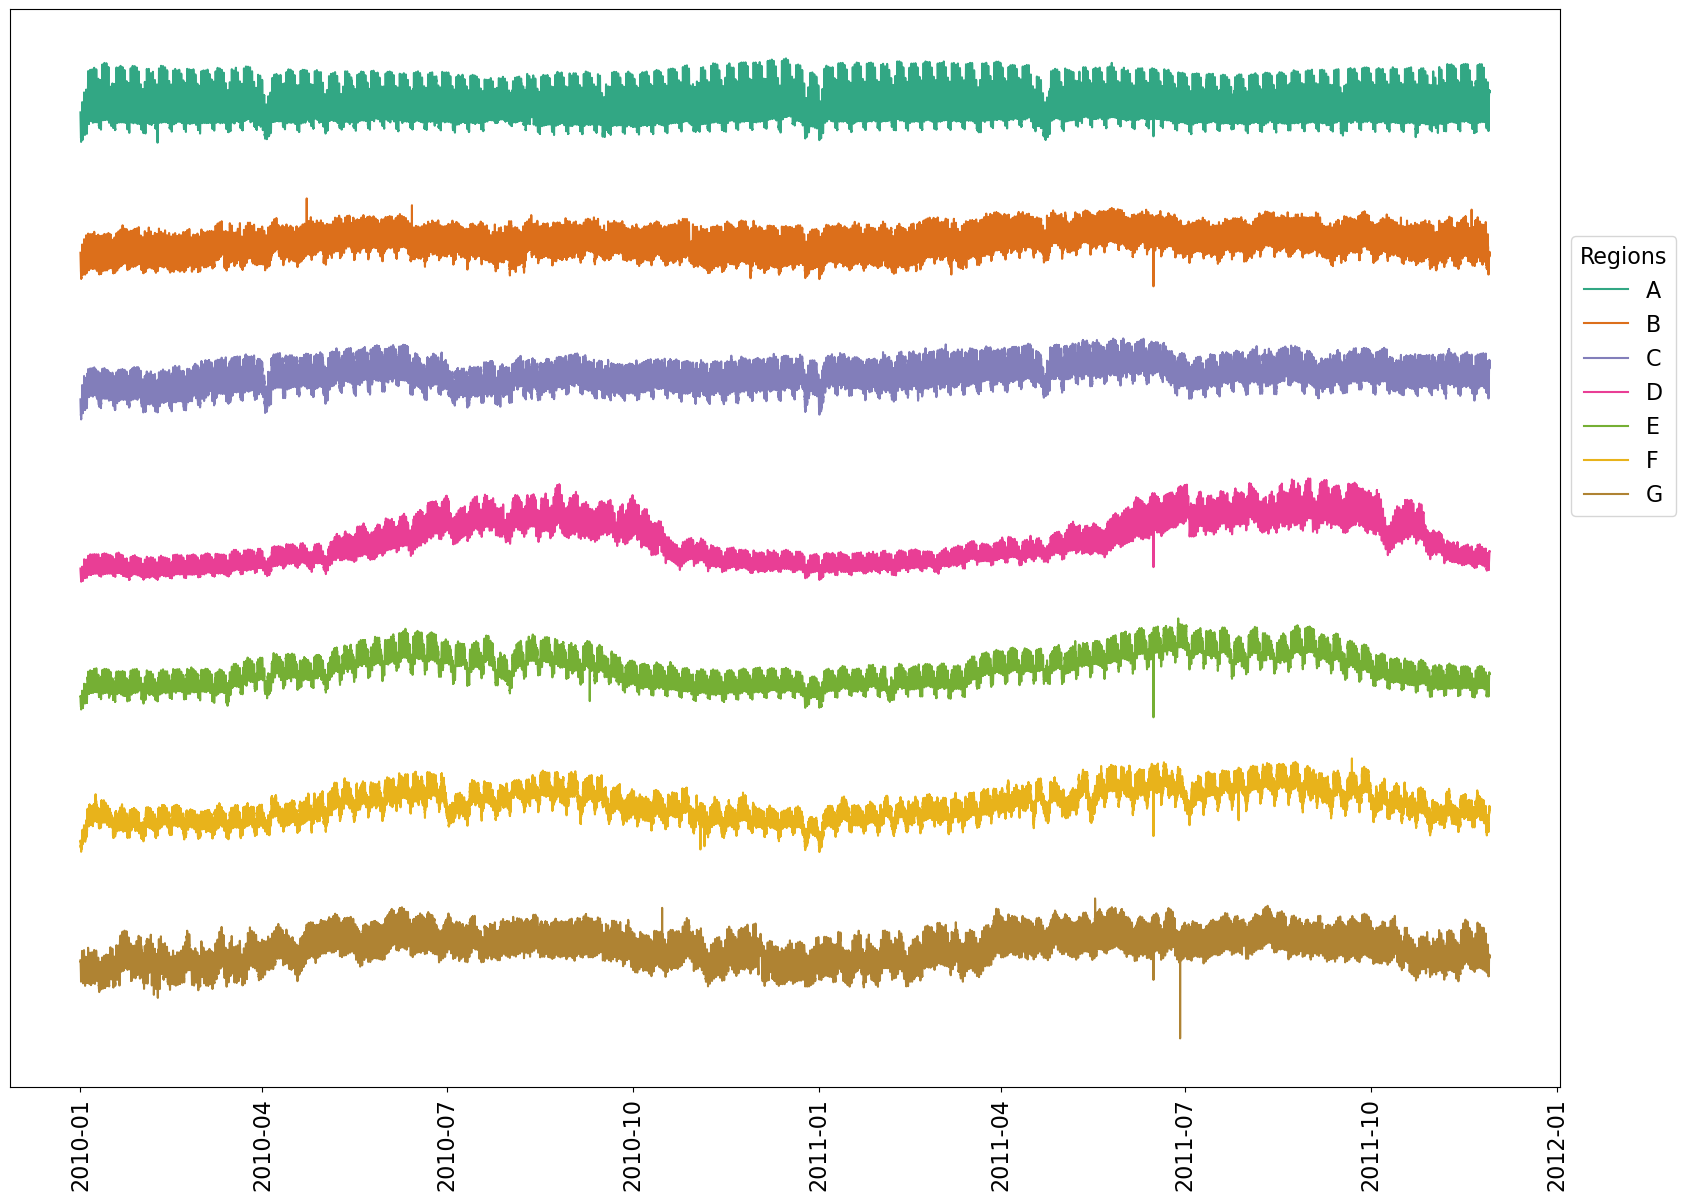

In [4]:
regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
if  True:
  i = 0
  j = 0
  cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
  fig, ax = plt.subplots(figsize=(20,14))
  for ts in df_5:
    max_t = df_5[ts].max()
    plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label=regions[i], alpha=.9)
    i += 1
    j -= 1
  plt.yticks([])
  plt.xticks(rotation=90, fontsize=16)
  plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16}, title="Regions", title_fontsize=16)
  #plt.savefig('series.pdf', bbox_inches = 'tight')
  plt.show()

In [5]:
df_serie4 = df_5[['SERIE4']]

## MSTL

In [6]:
models = [MSTL(
    season_length=[288, 288 * 7], # seasonalities of the time series 
    trend_forecaster = AutoARIMA() # model used to forecast trend
)]

In [7]:
sf = StatsForecast(
    models = models, # model used to fit each time series 
    freq = '5T', # frequency of the data,
    n_jobs = 4
)

In [8]:
# Transformaciones a estructura de statsforecast: https://nixtla.github.io/statsforecast/docs/tutorials/multipleseasonalities.html#load-data
df_nixtla = df_serie4.reset_index()
df_nixtla['unique_id'] = 'load_data'
df_nixtla.columns = ['ds', 'y', 'unique_id']
df_nixtla

,ds,y,unique_id
0,2010-01-01 00:00:00,1355.909058,load_data
1,2010-01-01 00:05:00,1353.716626,load_data
2,2010-01-01 00:10:00,1346.924121,load_data
3,2010-01-01 00:15:00,1346.241382,load_data
4,2010-01-01 00:20:00,1334.846802,load_data
...,...,...,...
200634,2011-11-28 15:30:00,1824.311914,load_data
200635,2011-11-28 15:35:00,1832.722339,load_data
200636,2011-11-28 15:40:00,1830.256812,load_data
200637,2011-11-28 15:45:00,1824.559302,load_data


In [9]:
sf = sf.fit(df = df_nixtla)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

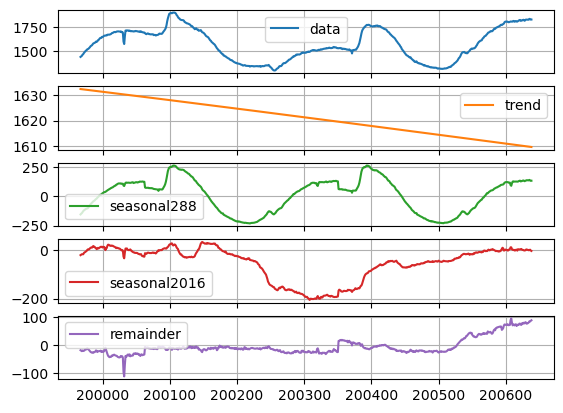

In [10]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)

In [11]:
forecasts = sf.predict(h = 288, level = [95])
forecasts.head()

,ds,MSTL,MSTL-lo-95,MSTL-hi-95
unique_id,,,,
load_data,2011-11-28 15:55:00,1736.140503,1725.301025,1746.979980
load_data,2011-11-28 16:00:00,1736.983032,1723.158447,1750.807617
load_data,2011-11-28 16:05:00,1738.405151,1722.170166,1754.640137
load_data,2011-11-28 16:10:00,1737.222778,1718.940552,1755.505005
load_data,2011-11-28 16:15:00,1736.361694,1716.208374,1756.514893


In [14]:
sf.plot(df_nixtla.iloc[-288 * 7 * 4 * 3 :], forecasts, max_insample_length = 288 * 7)

## Recursos

- https://nixtla.github.io/statsforecast/src/core/models.html#mstl